# Travel Process Management

## 1. Setup
To prepare your environment, you need to install some packages and enter credentials for the Watson services.

### 1.1 Install the necessary packages
You need the latest versions of the following packages:

#### Install IBM Cloud Object Storage Client: 

In [1]:
# !pip install ibm-cos-sdk

#### Install tree_decode: 

In [2]:
!pip install tree_decode

Requirement not upgraded as not directly required: tree_decode in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: scikit-learn>=0.17 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from tree_decode)


#### Install graphviz: 

In [3]:
!pip install graphviz

Requirement not upgraded as not directly required: graphviz in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages


#### Install pydot: 

In [4]:
!pip install pydot

Requirement not upgraded as not directly required: pydot in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: pyparsing>=2.1.4 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pydot)


### 1.2 Import packages and libraries

In [5]:
import graphviz
import pydot
import tree_decode as td
import numpy as np
import pandas as pd
import ibm_boto3
import csv

from io import StringIO
from botocore.client import Config
from sklearn.tree import _tree
from collections import defaultdict
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import _tree
from collections import OrderedDict



/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2. Configuration

Add configurable items of the notebook below

### 2.2 Add your service credentials for Object Storage

You must create Object Storage service on IBM Cloud. To access data in a file in Object Storage, you need the Object Storage authentication credentials. Insert the Object Storage authentication credentials as credentials_1 in the following cell after removing the current contents in the cell.


In [6]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IBM_API_KEY_ID': '5hXOMCDifSIqqWOghrh-ZEqsJUmdp_1GG5lagE_-RwoT',
    'IAM_SERVICE_ID': 'iam-ServiceId-65be6fd4-7424-4a1b-8dcb-044538998f6e',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'travelprocessmanagement-donotdelete-pr-exgxpknefmd9b3',
    'FILE': 'Travel Process_final.xlsx - Decision Tree.csv'
}


### 2.3 Global Variables

Add Global Variables

In [7]:
questions={'Travel Type': 'What type of Travel is it?(Cust/ Non_cust)',
 'Travel Purpose': 'What is the Travel Purpose?(Deal/PMR/Training/Conf)',
 'Travel Restrictions': 'Are there any Travel Restrictions?(Low/High/WW)',
 'Billable': 'Is it Billable?(Y/N)',
 'Estimated cost': 'What is the Estimated cost?(Low/High)',
 'WW Approval': 'Is it WW Approval?(Y/N)',
 'Local Skills Exsit': 'Do Local Skills Exsit?(Y/N)',
 'Customer stratigic': 'How important is Customer stratigic?(High/Low)',
 'PMR Exist': 'Does PMR Exist?(Y/N)',
 'PMR severity': 'What is the PMR severity?(1/2/3)',
 'SalesConnect Exist': 'Does SalesConnect Exist?(Y/N)',
 'Customer sentiments': 'What is the Customer sentiment?(Positive/Negative/Neutral)',
 'How Many people traveling': 'How Many people traveling?(1/2/3)',
 'Role of Person': 'What is the Role of the Person?(Critical/Important)',
 'Visit number': 'Do you have a Visit number?',
 'Revenue Impact': 'What is the Revenue Impact?(High/Low)',
 'Deal Closure Time': 'How long is the Deal Closure Time?(Next Q/Long term/Next 9 months/Next 6 months)',
 'Conference Flag': 'Does Conference Flag exist?(Repute/No)',
 'Speaker': 'Are you a Speaker?(Y/N)',
 'Trainimg': 'Are you Trainimg?(Y/N)',
 'Number of Aud.': 'What is the Number of Aud.?(Large/Small)',
 'Is Aud. decsion maker': 'Are Aud. the decsion makers?(Y/N)'}

searchFeature = 'Estimated cost=High' #Here we are taking all the paths that has 'Estimated cost' feature. 

## 3. Persistence and Storage

### 3.1 Configure Object Storage Client

In [8]:
cos = ibm_boto3.client('s3',
                    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                    config=Config(signature_version='oauth'),
                    endpoint_url=credentials_1['ENDPOINT'])

def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_1['BUCKET'], Key=filename)['Body']
    return fileobject

def load_string(fileobject):
    '''Load the file contents into a Python string'''
    text = fileobject.read()
    return text

## 4. Load and Preprocess Data
Csv data is loaded and cleaned. Apply nans to empty values.

In [9]:
''' Load Data into a Pandas Dataframe
'''
text= load_string(get_file(credentials_1['FILE'])).decode('utf8')
text = StringIO(text)
balance_data_excel = pd.read_csv(text, sep=",")
balance_data_excel

,Travel Type,Travel Purpose,Travel Restrictions,Billable,Estimated cost,WW Approval,Local Skills Exsit,Customer stratigic,PMR Exist,PMR severity,...,Role of Person,Visit number,Revenue Impact,Deal Closure Time,Conference Flag,Speaker,Trainimg,Number of Aud.,Is Aud. decsion maker,Recommendation
0,Cust,Deal,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Approve
1,Cust,Deal,WW,N,,Y,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Approve
2,Cust,Deal,WW,N,NaN,N,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Get WW Approval first
3,Cust,Deal,Low,N,,NaN,NaN,High,NaN,NaN,...,Critical,,High,Next Q,NaN,NaN,NaN,NaN,NaN,Approve
4,Cust,Deal,Low,N,,NaN,NaN,Low,NaN,NaN,...,Critical,,High,Next Q,NaN,NaN,NaN,NaN,NaN,Approve
5,Cust,Deal,Low,N,,NaN,NaN,High,NaN,NaN,...,Critical,,High,Next Q,NaN,NaN,NaN,NaN,NaN,Approve
6,Cust,Deal,Low,N,,NaN,NaN,High,NaN,NaN,...,Critical,,High,Next Q,NaN,NaN,NaN,NaN,NaN,Approve
7,Cust,Deal,Low,N,,NaN,NaN,High,NaN,NaN,...,Critical,,High,Next Q,NaN,NaN,NaN,NaN,NaN,Approve
8,Cust,Deal,Low,N,,NaN,NaN,High,NaN,NaN,...,Critical,,High,Next Q,NaN,NaN,NaN,NaN,NaN,Approve
9,Cust,Deal,Low,N,,NaN,Y,Low,NaN,NaN,...,Important,,Low,Long term,NaN,NaN,NaN,NaN,NaN,Use Local Skills


In [10]:
''' Clean the Data and replace with nan
'''
balance_data_excel = balance_data_excel.replace(r'^\s*$',str(np.nan),regex=True).replace('',str(np.nan))
balance_data_excel= balance_data_excel.applymap(str)
balance_data_excel

,Travel Type,Travel Purpose,Travel Restrictions,Billable,Estimated cost,WW Approval,Local Skills Exsit,Customer stratigic,PMR Exist,PMR severity,...,Role of Person,Visit number,Revenue Impact,Deal Closure Time,Conference Flag,Speaker,Trainimg,Number of Aud.,Is Aud. decsion maker,Recommendation
0,Cust,Deal,nan,Y,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,Approve
1,Cust,Deal,WW,N,nan,Y,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,Approve
2,Cust,Deal,WW,N,nan,N,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,Get WW Approval first
3,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,Critical,nan,High,Next Q,nan,nan,nan,nan,nan,Approve
4,Cust,Deal,Low,N,nan,nan,nan,Low,nan,nan,...,Critical,nan,High,Next Q,nan,nan,nan,nan,nan,Approve
5,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,Critical,nan,High,Next Q,nan,nan,nan,nan,nan,Approve
6,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,Critical,nan,High,Next Q,nan,nan,nan,nan,nan,Approve
7,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,Critical,nan,High,Next Q,nan,nan,nan,nan,nan,Approve
8,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,Critical,nan,High,Next Q,nan,nan,nan,nan,nan,Approve
9,Cust,Deal,Low,N,nan,nan,Y,Low,nan,nan,...,Important,nan,Low,Long term,nan,nan,nan,nan,nan,Use Local Skills


In [11]:
print ("Dataset Length:: ", len(balance_data_excel))
print ("Dataset Shape:: ", balance_data_excel.shape)

Dataset Length::  63
Dataset Shape::  (63, 23)


## 5. Prepare Dataset


### 5.1 Split Target Column

In [12]:
X = balance_data_excel.iloc[:, :-1]
y = balance_data_excel.iloc[:, 22]


In [13]:
X

,Travel Type,Travel Purpose,Travel Restrictions,Billable,Estimated cost,WW Approval,Local Skills Exsit,Customer stratigic,PMR Exist,PMR severity,...,How Many people traveling,Role of Person,Visit number,Revenue Impact,Deal Closure Time,Conference Flag,Speaker,Trainimg,Number of Aud.,Is Aud. decsion maker
0,Cust,Deal,nan,Y,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,Cust,Deal,WW,N,nan,Y,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,Cust,Deal,WW,N,nan,N,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,2,Critical,nan,High,Next Q,nan,nan,nan,nan,nan
4,Cust,Deal,Low,N,nan,nan,nan,Low,nan,nan,...,1,Critical,nan,High,Next Q,nan,nan,nan,nan,nan
5,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,1,Critical,nan,High,Next Q,nan,nan,nan,nan,nan
6,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,1,Critical,nan,High,Next Q,nan,nan,nan,nan,nan
7,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,1,Critical,nan,High,Next Q,nan,nan,nan,nan,nan
8,Cust,Deal,Low,N,nan,nan,nan,High,nan,nan,...,1,Critical,nan,High,Next Q,nan,nan,nan,nan,nan
9,Cust,Deal,Low,N,nan,nan,Y,Low,nan,nan,...,1,Important,nan,Low,Long term,nan,nan,nan,nan,nan


In [14]:
y

0                   Approve
1                   Approve
2     Get WW Approval first
3                   Approve
4                   Approve
5                   Approve
6                   Approve
7                   Approve
8                   Approve
9          Use Local Skills
10       get opportunity ID
11                  Approve
12                  Approve
13                  Approve
14                   Reject
15         Use Local Skills
16                   Reject
17                  Approve
18                  Approve
19                   Reject
20                  Approve
21         Use Local Skills
22         Use Local Skills
23                  Approve
24                  Approve
25                  Approve
26                  Approve
27    Get WW Approval first
28                  Approve
29                  Approve
              ...          
33                  Approve
34               Get PMR id
35                  Approve
36         Use local skills
37                  

### 5.2 Label Encoding

In [15]:
''' One-hot encoding is applied to all X columns specified in a pandas DataFrame.
'''

def encode_onehot(df, cols):
    vec = DictVectorizer()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(orient='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

X = encode_onehot(X, (X.columns.get_values()).tolist())
X.head()

,Billable=N,Billable=Y,Billable=nan,Conference Flag=No,Conference Flag=Repute,Conference Flag=nan,Conference Flag=repute,Customer sentiments=Negative,Customer sentiments=Neutral,Customer sentiments=Positive,...,Travel Restrictions=High,Travel Restrictions=Low,Travel Restrictions=WW,Travel Restrictions=nan,Travel Type=Cust,Travel Type=Non_cust,Visit number=nan,WW Approval=N,WW Approval=Y,WW Approval=nan
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [16]:
''' Applying Label Encoding on y target class column
'''
le_y = LabelEncoder()
y = le_y.fit_transform(y)


In [17]:
y

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 8, 0, 0, 0, 5, 6, 5, 0, 0, 5, 0, 6, 6,
       0, 0, 0, 0, 2, 0, 0, 3, 3, 5, 0, 1, 0, 7, 5, 0, 0, 4, 5, 0, 4, 4, 4,
       0, 0, 0, 0, 0, 5, 5, 0, 5, 5, 5, 0, 5, 5, 0, 5, 5])

### 5.3 Dropping nan columns

In [18]:
cols= X.columns
for c in cols:
    x = c
    if x.split('=')[1] == 'nan':
         X.drop(c, axis=1, inplace=True)


In [19]:
X

,Billable=N,Billable=Y,Conference Flag=No,Conference Flag=Repute,Conference Flag=repute,Customer sentiments=Negative,Customer sentiments=Neutral,Customer sentiments=Positive,Customer stratigic=High,Customer stratigic=Low,...,Travel Purpose=Deal,Travel Purpose=PMR,Travel Purpose=Training,Travel Restrictions=High,Travel Restrictions=Low,Travel Restrictions=WW,Travel Type=Cust,Travel Type=Non_cust,WW Approval=N,WW Approval=Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## 6. Build the Decision Tree Model

In [20]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.1, random_state = 100)

In [21]:
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=100, min_samples_leaf=5, min_samples_split=8)
abc = clf_entropy.fit(X_train, y_train)
abc

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=100,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

## 7. Accuracy Testing

In [22]:
y_pred = clf_entropy.predict(X_test)
y_pred

array([5, 3, 0, 5, 5, 0, 0])

In [23]:
print ("Accuracy is ", accuracy_score(y_test,y_pred)*100)

Accuracy is  85.7142857143


## 8. Plotting Decision Tree 

In [24]:
''' Convert Target Classes to key-value pairs
'''
class_names={ i:le_y.classes_[i] for i in range(len(le_y.classes_))}
print(class_names)

{0: 'Approve', 1: 'Get PMR id', 2: 'Get WW Approval first', 3: 'Postpone', 4: 'Reduce Cost', 5: 'Reject', 6: 'Use Local Skills', 7: 'Use local skills', 8: 'get opportunity ID'}


In [25]:

features={ i:X.columns[i] for i in range(len(list(X.columns[0:56])))}
#features

feature_names = [ X.columns[i] for i in range(len(list(X.columns[0:56])))]
#feature_names

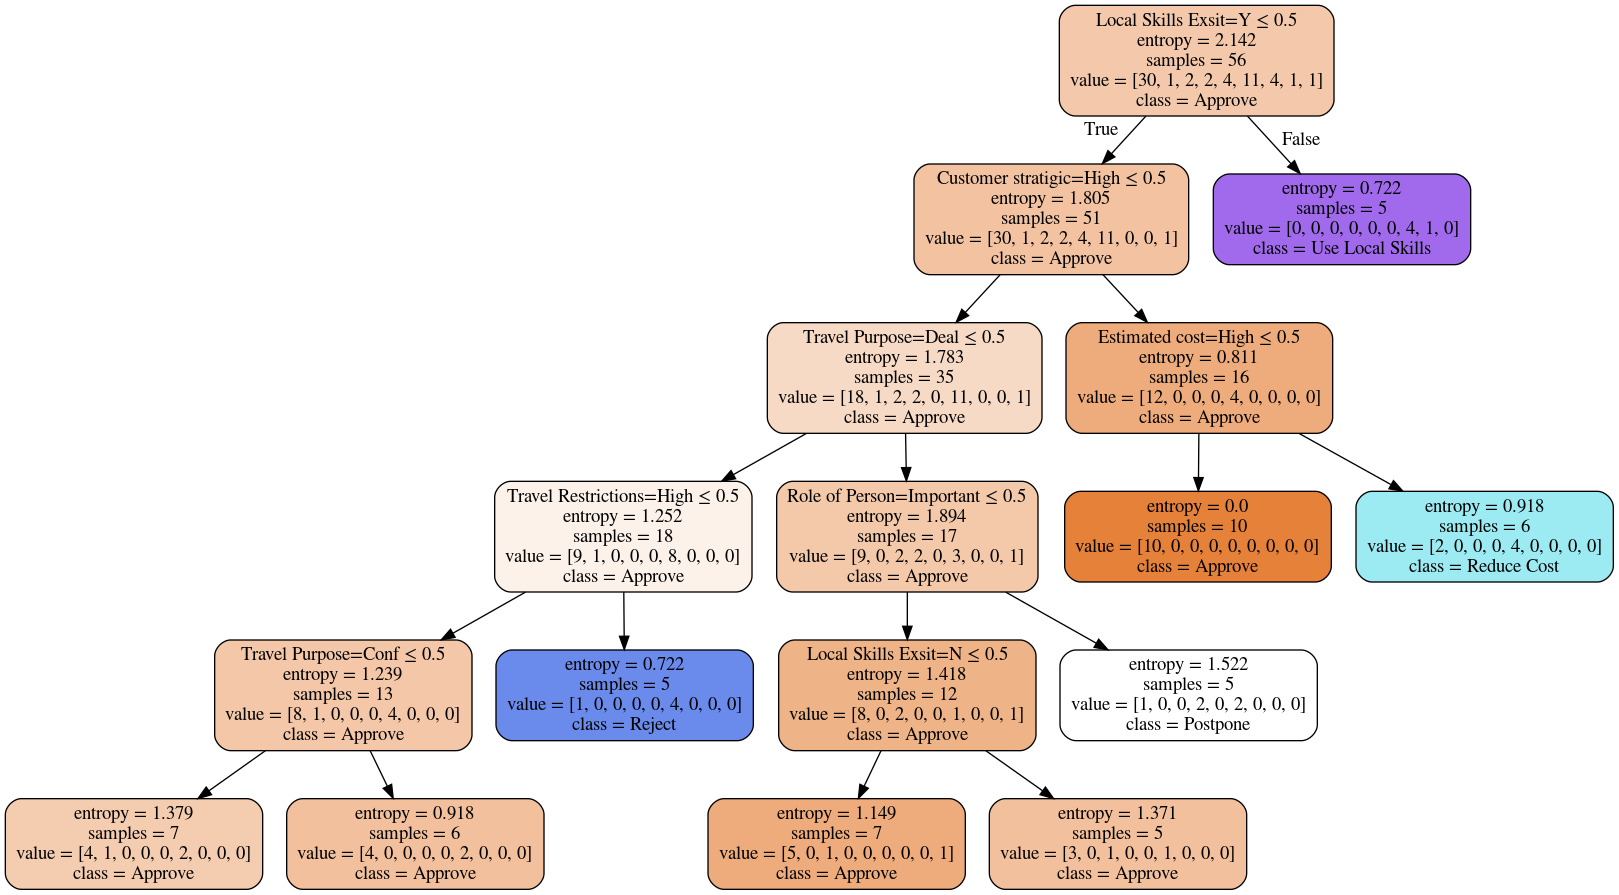

In [26]:
dot_data = StringIO()
export_graphviz(clf_entropy , out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=features, class_names=class_names)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

## 9. Traversing the tree

The built tree is decoded and paths are extracted.

### 9.1 Decoding the Tree

In [27]:
td.get_tree_info(model=abc,names=features,tab_size=10)

'\n\nInfo for Decision Tree 0\n\nnode=0: go to node 1 if Local Skills Exsit=Y <= 0.5 else to node 16.\n          node=1: go to node 2 if Customer stratigic=High <= 0.5 else to node 13.\n                    node=2: go to node 3 if Travel Purpose=Deal <= 0.5 else to node 8.\n                              node=3: go to node 4 if Travel Restrictions=High <= 0.5 else to node 7.\n                                        node=4: go to node 5 if Travel Purpose=Conf <= 0.5 else to node 6.\n                                                  node=5 left node: scores = [[ 0.571  0.143  0.     0.     0.     0.286  0.     0.     0.   ]]\n                                                  node=6 left node: scores = [[ 0.667  0.     0.     0.     0.     0.333  0.     0.     0.   ]]\n\n                                        node=7 left node: scores = [[ 0.2  0.   0.   0.   0.   0.8  0.   0.   0. ]]\n\n                              node=8: go to node 9 if Role of Person=Important <= 0.5 else to node 12.\n

In [28]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    '''class_name = [
        class_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree.classes_
    ]'''
    print ("def tree({}):".format(", ".join(feature_name)))
    '''print ("def tree({}):".format(", ".join(class_name)))'''
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print( "{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print( "{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [29]:
tree_to_code(abc,features)

def tree(Local Skills Exsit=Y, Customer stratigic=High, Travel Purpose=Deal, Travel Restrictions=High, Travel Purpose=Conf, undefined!, undefined!, undefined!, Role of Person=Important, Local Skills Exsit=N, undefined!, undefined!, undefined!, Estimated cost=High, undefined!, undefined!, undefined!):
  if Local Skills Exsit=Y <= 0.5:
    if Customer stratigic=High <= 0.5:
      if Travel Purpose=Deal <= 0.5:
        if Travel Restrictions=High <= 0.5:
          if Travel Purpose=Conf <= 0.5:
            return [[ 4.  1.  0.  0.  0.  2.  0.  0.  0.]]
          else:  # if Travel Purpose=Conf > 0.5
            return [[ 4.  0.  0.  0.  0.  2.  0.  0.  0.]]
        else:  # if Travel Restrictions=High > 0.5
          return [[ 1.  0.  0.  0.  0.  4.  0.  0.  0.]]
      else:  # if Travel Purpose=Deal > 0.5
        if Role of Person=Important <= 0.5:
          if Local Skills Exsit=N <= 0.5:
            return [[ 5.  0.  1.  0.  0.  0.  0.  0.  1.]]
          else:  # if Local Skills Exsit

### 9.2 Extract the Paths

In [30]:
tags=[]
des=[]
paths=[]

def tree_to_code(tree, feature_names,searchFeature):
    tree_ = tree.tree_
    
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
#     print(feature_name)
    class_name = [
        class_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree.classes_
    ]

    def recurse(node, depth, tag):
        if(not tree_.feature[node]):
            return
        
            
        if tree_.feature[node] == _tree.TREE_UNDEFINED:
            x=np.argmax(max(tree_.value[node]))
            tags.append(tag)
            des.append(class_names[x])
            
            if searchFeature in  des:
                y = OrderedDict(zip(des, tags))
                paths.append(y)
                    
                print(des)
                
                print(tags)

            
        else:
#             print("hi")
            tags.append(tag)
            #print(tags)
            des.append(feature_name[node])
            #print(des)
            recurse(tree_.children_left[node], depth + 1,'left')
            des.pop(-1)
            tags.pop(-1)
            recurse(tree_.children_right[node], depth + 1,'right')
            des.pop(-1)
            tags.pop(-1)
        

    recurse(0, 1, 'NULL')

In [31]:
tree_to_code(abc,features,searchFeature)

['Local Skills Exsit=Y', 'Customer stratigic=High', 'Estimated cost=High', 'Approve']
['NULL', 'left', 'right', 'left']
['Local Skills Exsit=Y', 'Customer stratigic=High', 'Estimated cost=High', 'Reduce Cost']
['NULL', 'left', 'right', 'right']


In [32]:
paths

[OrderedDict([('Local Skills Exsit=Y', 'NULL'),
              ('Customer stratigic=High', 'left'),
              ('Estimated cost=High', 'right'),
              ('Approve', 'left')]),
 OrderedDict([('Local Skills Exsit=Y', 'NULL'),
              ('Customer stratigic=High', 'left'),
              ('Estimated cost=High', 'right'),
              ('Reduce Cost', 'right')])]

In [33]:
for i in paths:
    for k,v in i.items():
        print (k+' : '+v)
    print("-----------------------------------")    

Local Skills Exsit=Y : NULL
Customer stratigic=High : left
Estimated cost=High : right
Approve : left
-----------------------------------
Local Skills Exsit=Y : NULL
Customer stratigic=High : left
Estimated cost=High : right
Reduce Cost : right
-----------------------------------


## 10. Questions

Questions provided by the users are answered by traversing the path obtained from the previous step. The final outcome class is provided as per the conditions provided by the user

In [34]:
def question_and_answer(): 
    var = 'null'
    f='true'
    for i in paths:
        if f=='true': 
            var = 'null'
            for k,v in i.items():
                flag =''
                if v=='NULL' or v==var or var=='null':
                    flag='true'
                else:
                    flag='false'
                if flag=='true':
                    c = k
                    if c in feature_names:
                        n = c.split('=')[0]
                        ans=c.split('=')[1]
                    else:
                        n=c
                    if n in questions:
                        a = input(questions[n])
                        if a.lower()==ans.lower():
                            var='left'
                        else:
                            var='right'
                    else:
                        print(n)
                        f='false'
                else:
                    var='abc'

            print("-----------------------------------")
    if f=='true':
        print('Your inputs are not defined')
question_and_answer()

Do Local Skills Exsit?(Y/N)Y
How important is Customer stratigic?(High/Low)Low
What is the Estimated cost?(Low/High)High
Approve
-----------------------------------
